In [1]:
import os
from pathlib import Path
import numpy as np
import mne
from scipy import stats
import pandas as pd
import random

# Use neurodsp for convenience
from neurodsp.plts import plot_time_series, plot_power_spectra
from neurodsp.spectral import compute_spectrum

# Import fooof for checking model fits
from fooof import FOOOF
from fooof import FOOOFGroup
from fooof.plts.annotate import plot_annotated_model, plot_annotated_model2
from fooof.utils.params import compute_knee_frequency

# Plotting functions
from spiketools.plts.utils import make_axes
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import table 

import warnings
warnings.filterwarnings("ignore")

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold

In [5]:
# Import custom project code
import sys
sys.path.append("/home/b1044271/Columbia/Aperiodic_sleep/Aperiodic_sleep_paper/helpers")
from utils import check_distribution, perform_correlation, compute_z_values, bonferroni_correction, friedman_dunns

In [6]:
f_min = 1
f_max = 45
t     = 15
fs    = 200
SETTINGS_W  = { 'method' : 'welch', 'average' : None, 'fmin' :f_min , 'fmax':f_max, 'n_fft': fs*t, 'n_overlap': fs*t*0.5}

SETTINGS_F1={'max_n_peaks':8, 'aperiodic_mode':'knee'}
SETTINGS_F2={'max_n_peaks':8, 'aperiodic_mode':'fixed'}

In [7]:
# Set data path
data_path = Path('/home/b1044271/Columbia/iEEG')
# Set result path
result_path = Path('/home/b1044271/Columbia/Results/iEEG')
# Set dataset
dataset = 'Wakefulness_AllRegions'
# Get list of files, which correspond to regions
regions = np.sort(os.listdir(data_path / dataset))

In [8]:
W_Kn  = np.zeros([len(regions)-4,20000])*np.nan
W_Exp = np.zeros([len(regions)-4,20000])*np.nan
W_Exp2 = np.zeros([len(regions)-4,20000])*np.nan

N2_Kn  = np.zeros([len(regions)-4,20000])*np.nan
N2_Exp = np.zeros([len(regions)-4,20000])*np.nan
N2_Exp2 = np.zeros([len(regions)-4,20000])*np.nan

N3_Kn  = np.zeros([len(regions)-4,20000])*np.nan
N3_Exp = np.zeros([len(regions)-4,20000])*np.nan
N3_Exp2 = np.zeros([len(regions)-4,20000])*np.nan

R_Kn  = np.zeros([len(regions)-4,20000])*np.nan
R_Exp = np.zeros([len(regions)-4,20000])*np.nan
R_Exp2 = np.zeros([len(regions)-4,20000])*np.nan

In [ ]:
# WAKEFULNESS
i =0 

for C, V in enumerate(regions):
    
    if C == 0 or C== 8 or C==10 or C==35:
        continue
        
    EEG = mne.io.read_raw_edf(data_path / dataset / V)
    EEG_psd = EEG.compute_psd(**SETTINGS_W)
    
    X = EEG_psd._data.transpose(2,0,1)
    Xn = X.reshape((X.shape[0]*X.shape[1]), X.shape[2])
       
    fm1 = FOOOFGroup(**SETTINGS_F1)
    fm1.fit(EEG_psd._freqs, Xn, [EEG_psd._freqs[0] , EEG_psd._freqs[-1]])
        
    fm2 = FOOOFGroup(**SETTINGS_F2)
    fm2.fit(EEG_psd._freqs, Xn, [EEG_psd._freqs[0] , EEG_psd._freqs[-1]])
            
    # parameters exctract
    W_Kn[i,0:len(fm1.get_params('aperiodic_params','knee'))]  = fm1.get_params('aperiodic_params','knee')
    W_Exp[i,0:len(fm1.get_params('aperiodic_params','exponent'))] = fm1.get_params('aperiodic_params','exponent')
    W_Exp2[i,0:len(fm2.get_params('aperiodic_params','exponent'))] = fm2.get_params('aperiodic_params','exponent')
   

    i = i+1

Extracting EDF parameters from /home/b1044271/Columbia/iEEG/Wakefulness_AllRegions/Angular gyrus_W.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Effective window size : 15.000 (s)
Running FOOOFGroup across 424 power spectra.
Running FOOOFGroup across 424 power spectra.
Extracting EDF parameters from /home/b1044271/Columbia/iEEG/Wakefulness_AllRegions/Anterior cingulate_W.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Effective window size : 15.000 (s)
Running FOOOFGroup across 248 power spectra.
Running FOOOFGroup across 248 power spectra.
Extracting EDF parameters from /home/b1044271/Columbia/iEEG/Wakefulness_AllRegions/Anterior insula_W.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Effective window size : 15.000 (s)
Running FOOOFGroup across 568 power spectra.
Running FOOOFGroup across 568 power spectra.
Extracting EDF parameters from /home/b1044271/Colum

In [ ]:
#N2
# Set data path
data_path = Path('/home/b1044271/Columbia/iEEG')
# Set dataset
dataset = 'N2_AllRegions'
# Get list of files, which correspond to regions
regions = np.sort(os.listdir(data_path / dataset))

PSDs_N2 =  np.zeros([len(regions)-4,661])*np.nan

i =0

for C, V in enumerate(regions):
    
    if C == 0 or C== 8 or C==10 or C==35:
        continue
        
    EEG = mne.io.read_raw_edf(data_path / dataset / V)
    EEG_psd = EEG.compute_psd(**SETTINGS_W)
        
    X = EEG_psd._data.transpose(2,0,1)
    Xn = X.reshape((X.shape[0]*X.shape[1]), X.shape[2])
       
    fm1 = FOOOFGroup(**SETTINGS_F1)
    fm1.fit(EEG_psd._freqs, Xn, [EEG_psd._freqs[0] , EEG_psd._freqs[-1]])
        
    fm2 = FOOOFGroup(**SETTINGS_F2)
    fm2.fit(EEG_psd._freqs, Xn, [EEG_psd._freqs[0] , EEG_psd._freqs[-1]])
            
    # parameters exctract
    N2_Kn[i,0:len(fm1.get_params('aperiodic_params','knee'))]  =fm1.get_params('aperiodic_params','knee')
    N2_Exp[i,0:len(fm1.get_params('aperiodic_params','exponent'))] = fm1.get_params('aperiodic_params','exponent')
    N2_Exp2[i,0:len(fm2.get_params('aperiodic_params','exponent'))] = fm2.get_params('aperiodic_params','exponent')
     
    i = i+1

In [ ]:
# N3
# Set data path
data_path = Path('/home/b1044271/Columbia/iEEG')
# Set dataset
dataset = 'N3_AllRegions'
# Get list of files, which correspond to regions
regions = np.sort(os.listdir(data_path / dataset))

i =0
for C, V in enumerate(regions):
    
    if C == 0 or C== 8 or C==10 or C==35:
        continue
        
    EEG = mne.io.read_raw_edf(data_path / dataset / V)
    EEG_psd = EEG.compute_psd(**SETTINGS_W)
        
    X = EEG_psd._data.transpose(2,0,1)
    Xn = X.reshape((X.shape[0]*X.shape[1]), X.shape[2])
       
    fm1 = FOOOFGroup(**SETTINGS_F1)
    fm1.fit(EEG_psd._freqs, Xn, [EEG_psd._freqs[0] , EEG_psd._freqs[-1]])
        
    fm2 = FOOOFGroup(**SETTINGS_F2)
    fm2.fit(EEG_psd._freqs, Xn, [EEG_psd._freqs[0] , EEG_psd._freqs[-1]])
        
    # parameters exctract
    N3_Kn[i,0:len(fm1.get_params('aperiodic_params','knee'))]  = fm1.get_params('aperiodic_params','knee')
    N3_Exp[i,0:len(fm1.get_params('aperiodic_params','exponent'))] = fm1.get_params('aperiodic_params','exponent')
    N3_Exp2[i,0:len(fm2.get_params('aperiodic_params','exponent'))] = fm2.get_params('aperiodic_params','exponent')
   
    i = i+1

In [ ]:
# REM 
# Set data path
data_path = Path('/home/b1044271/Columbia/iEEG')
# Set dataset
dataset = 'REM_AllRegions'
# Get list of files, which correspond to regions
regions = np.sort(os.listdir(data_path / dataset))

i =0
for C, V in enumerate(regions):
    
    if C == 0 or C== 8 or C==10 or C==35:
        continue
        
    EEG = mne.io.read_raw_edf(data_path / dataset / V)
    EEG_psd = EEG.compute_psd(**SETTINGS_W)
    
    X = EEG_psd._data.transpose(2,0,1)
    Xn = X.reshape((X.shape[0]*X.shape[1]), X.shape[2])
       
    fm1 = FOOOFGroup(**SETTINGS_F1)
    fm1.fit(EEG_psd._freqs, Xn, [EEG_psd._freqs[0] , EEG_psd._freqs[-1]])
        
    fm2 = FOOOFGroup(**SETTINGS_F2)
    fm2.fit(EEG_psd._freqs, Xn, [EEG_psd._freqs[0] , EEG_psd._freqs[-1]])
            
    # parameters exctract
    R_Kn[i,0:len(fm1.get_params('aperiodic_params','knee'))]  = fm1.get_params('aperiodic_params','knee')
    R_Exp[i,0:len(fm1.get_params('aperiodic_params','exponent'))] = fm1.get_params('aperiodic_params','exponent')
    R_Exp2[i,0:len(fm2.get_params('aperiodic_params','exponent'))] = fm2.get_params('aperiodic_params','exponent')

    i = i+1

# KNEE calculations

In [143]:
# Compute knee frequency
Kn_W = compute_knee_frequency(W_Kn, W_Exp)
Kn_N2 = compute_knee_frequency(N2_Kn, N2_Exp)
Kn_N3 = compute_knee_frequency(N3_Kn, N3_Exp)
Kn_R = compute_knee_frequency(R_Kn, R_Exp)

# DECODING

In [145]:
# repititions and 
lin_method = RepeatedStratifiedKFold (n_splits = 5, n_repeats = 2, random_state = 1)

# Set up the repeated k-fold cross-validation
lin_method = RepeatedKFold(n_splits=5, n_repeats=2)


random.seed(0)

trials=np.zeros(34)*np.nan

accuracy_K=[]
accuracy_F=[]
accuracy_knee=[]


for i in np.arange(34):

    # Initialize the LDA classifier
    lda = LinearDiscriminantAnalysis()
 ##################################################   
    # DATA
    W_exp   = W_Exp[i][~np.isnan(W_Exp[i])]
    W_knee  = Kn_W[i][~np.isnan(Kn_W[i])]
    mask = np.isfinite(W_knee)
    W_knee = W_knee[mask]
    W_exp2  = W_Exp2[i][~np.isnan(W_Exp2[i])]

    N2_exp   = N2_Exp[i][~np.isnan(N2_Exp[i])]
    N2_knee  = Kn_N2[i][~np.isnan(Kn_N2[i])]
    N2_exp2  = N2_Exp2[i][~np.isnan(N2_Exp2[i])]

    N3_exp   = N3_Exp[i][~np.isnan(N3_Exp[i])]
    N3_knee  = Kn_N3[i][~np.isnan(Kn_N3[i])]
    N3_exp2  = N3_Exp2[i][~np.isnan(N3_Exp2[i])]

    R_exp   = R_Exp[i][~np.isnan(R_Exp[i])]
    R_knee  = Kn_R[i][~np.isnan(Kn_R[i])]
    R_exp2  = R_Exp2[i][~np.isnan(R_Exp2[i])]

    ###################################################
         # equate number of trials per stage
    L  = min([len(W_exp) ,  len(N2_exp), len(N3_exp),  len(R_exp),
               len(W_knee) , len(N2_knee), len(N3_knee),  len(R_knee),
               len(W_exp2) , len(N2_exp2), len(N3_exp2),  len(R_exp2)])
    
    trials[i] = L
    
    W_exp  = W_exp[random.sample(range(0, len(W_exp)), L)] 
    l1  = np.ones(len(W_exp))
 
    N2_exp = N2_exp[random.sample(range(0, len(N2_exp)), L)]
    l2  = np.ones(len(N2_exp))*2

    N3_exp = N3_exp[random.sample(range(0, len(N3_exp)), L)]
    l3  = np.ones(len(N3_exp))*3
    
    R_exp  = R_exp[random.sample(range(0, len(R_exp)), L)]
    l4  = np.ones(len(R_exp))*4
    
    #########################################
    W_exp2  = W_exp2[random.sample(range(0, len(W_exp2)), L)] 
    N2_exp2 = N2_exp2[random.sample(range(0, len(N2_exp2)), L)]
    N3_exp2 = N3_exp2[random.sample(range(0, len(N3_exp2)), L)]
    R_exp2  = R_exp2[random.sample(range(0, len(R_exp2)), L)]

    ############################################    
    W_knee  = W_knee[random.sample(range(0, len(W_knee)), L)] 
    N2_knee = N2_knee[random.sample(range(0, len(N2_knee)), L)]  
    N3_knee = N3_knee[random.sample(range(0, len(N3_knee)), L)]
    R_knee  = R_knee[random.sample(range(0, len(R_knee)), L)]

    
    Knee_model  = np.concatenate((W_exp,N2_exp,N3_exp,R_exp))
    Fixed_model  = np.concatenate((W_exp2,N2_exp2,N3_exp2,R_exp2))
    Knee_value  = np.concatenate((W_knee,N2_knee,N3_knee,R_knee))

    y = np.concatenate((l1,l2,l3,l4))
    ###########################################
    
    # make the 1d array a 2d array (req for scikit learn)
    X=Knee_model[:, None]
    X2=Fixed_model[:, None]
    X3=Knee_value[:, None]

    ################################################
    # Loop over the cross-validation folds and repetitions
    lin_score = cross_val_score(lda, X, y, scoring = 'accuracy', cv = lin_method, n_jobs = -1)
    # Split the data into training and test sets
    X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.2)
    # Fit the LDA model on the training data
    lda.fit(X_train, y_train)
    # Evaluate the model on the test data
    accuracy_K.append(lda.score(X_test, y_test))
    

    # Initialize the LDA classifier
    lda2 = LinearDiscriminantAnalysis()
    # Loop over the cross-validation folds and repetitions
    lin_score2 = cross_val_score(lda2, X2, y, scoring = 'accuracy', cv = lin_method, n_jobs = -1)
    # Split the data into training and test sets
    X_train2, X_test2 , y_train2, y_test2 = train_test_split(X2, y, test_size=0.2)
    # Fit the LDA model on the training data
    lda2.fit(X_train2, y_train2)
    # Evaluate the model on the test data
    accuracy_F.append(lda2.score(X_test2, y_test2))
    
    # Initialize the LDA classifier
    lda3 = LinearDiscriminantAnalysis()
    # Loop over the cross-validation folds and repetitions
    lin_score3 = cross_val_score(lda3, X3, y, scoring = 'accuracy', cv = lin_method, n_jobs = -1)
    # Split the data into training and test sets
    X_train3, X_test3 , y_train3, y_test3 = train_test_split(X3, y, test_size=0.2)
    # Fit the LDA model on the training data
    lda3.fit(X_train3, y_train3)
    # Evaluate the model on the test data
    accuracy_knee.append(lda3.score(X_test3, y_test3))

trials

array([6., 8., 8., 8., 8., 8., 7., 5., 8., 8., 8., 5., 8., 8., 8., 8., 8.,
       3., 7., 4., 7., 8., 7., 3., 8., 7., 8., 8., 6., 8., 8., 3., 8., 8.])

In [146]:
np.mean(trials*5)

35.0

# STATS

In [ ]:
# FIRST PERMUTATION

from utils import calculate_t_statistic, calculate_cohens_d, perform_permutation_test

ACC = [accuracy_knee,accuracy_K, accuracy_F]

# Specify the number of permutations
num_permutations = 10000

tvalue=np.zeros(3)
pvalue=np.zeros(3)
cohend=np.zeros(3)
for i in np.arange(len(ACC)):
    X = ACC[i]
    # Perform the permutation test
    tvalue[i],pvalue[i],cohend[i] = perform_permutation_test(X, np.ones(17)*0.25, num_permutations)

pvalue_bonf = pvalue * len(ACC)

pvalue_bonf

In [ ]:
# THEN FRIEDMAN
# Decoding stats repeated measures
data = pd.DataFrame(np.transpose(ACC))

friedman_result, W, posthoc_result, z_values, effect_sizes, corrected_p_values = friedman_dunns(data)

# Change the column names
effect_sizes.columns =['Knee', 'Exp_K', 'Exp_F']
corrected_p_values.columns = ['Knee', 'Exp_K', 'Exp_F']
# Change the row indexes
effect_sizes.index = ['Knee', 'Exp_K', 'Exp_F']
corrected_p_values.index = ['Knee', 'Exp_K', 'Exp_F']

ax = plt.subplot(111, frame_on=False) # no visible frame
table(ax, effect_sizes)  # where df is your data frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
plt.savefig('/home/b1044271/Columbia/Plots/NOV23/Stats/Decode_iEEG_effectS.svg')

ax = plt.subplot(111, frame_on=False) # no visible frame
table(ax, corrected_p_values)  # where df is your data frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
plt.savefig('/home/b1044271/Columbia/Plots/NOV23/Stats/Decode_iEEG_Pvalues.svg')

# Plotting Accuracies

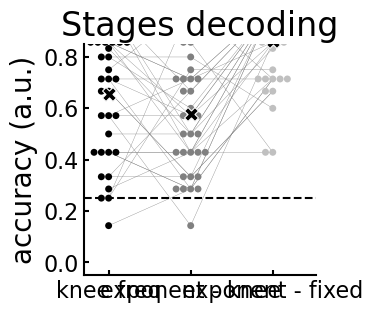

In [147]:
array_list6 = [accuracy_knee,accuracy_K, accuracy_F]
colors = ['black', 'grey', 'silver']

import seaborn
titles =  ['knee freq','exponent - knee','exponent - fixed']


ax = plt.figure(figsize=(3,3))  

ax = seaborn.swarmplot(data=array_list6, palette = colors);
ax.set_xticklabels(titles)

seaborn.scatterplot(x=[0,1,2], y=np.mean(array_list6,1), marker='X', color='black', s=100, zorder=4, legend=False);
plt.plot([array_list6[0], array_list6[1], array_list6[2]], color = 'grey', linewidth = 0.25, linestyle = '-');
ax.axhline(y=0.25, color='black', linestyle='--');

plt.title('Stages decoding', fontsize = 24)
plt.ylabel('accuracy (a.u.)',fontsize=20)

plt.ylim(-0.05, 0.85)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='both', direction='in', width=1.5, labelsize=16)  # Customize tick properties
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)


#plt.savefig("/home/b1044271/Columbia/Plots/NOV23/iEEG_decoding.svg", dpi = 600)
plt.show()

In [127]:
# Set data path
data_path = Path('/home/b1044271/Columbia/iEEG')
# Set dataset
dataset = 'REM_AllRegions'
# Get list of files, which correspond to regions
regions = np.sort(os.listdir(data_path / dataset))

PSDs_R =  np.zeros([len(regions)-4,661])*np.nan

i =0 
for C, V in enumerate(regions):
    
    if C == 0 or C== 8 or C==10 or C==35:
        continue
        
    EEG = mne.io.read_raw_edf(data_path / dataset / V)
    EEG_psd = EEG.compute_psd(**SETTINGS_W)
    
    PSDs_R[i,0:661] = np.mean(EEG_psd._data,0)
    
    fm1 = FOOOFGroup(**SETTINGS_F1)
    fm1.fit(EEG_psd._freqs, EEG_psd._data, [EEG_psd._freqs[0] , EEG_psd._freqs[-1]])
     
    fm2 = FOOOFGroup(**SETTINGS_F2)
    fm2.fit(EEG_psd._freqs, EEG_psd._data, [EEG_psd._freqs[0] , EEG_psd._freqs[-1]])
    # parameters exctract
    R_Kn[i,0:len(EEG_psd._data)]  = fm1.get_params('aperiodic_params','knee')
    R_Exp[i,0:len(EEG_psd._data)] = fm1.get_params('aperiodic_params','exponent')
    
    R_Exp2[i,0:len(EEG_psd._data)] = fm2.get_params('aperiodic_params','exponent')
    
    R_R2K[i,0:len(EEG_psd._data)] = fm1.get_params('r_squared')
    R_R2N[i,0:len(EEG_psd._data)] = fm2.get_params('r_squared')

    i = i+1

Extracting EDF parameters from /home/b1044271/Columbia/iEEG/REM_AllRegions/Angular gyrus_R.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Effective window size : 15.000 (s)


ValueError: could not broadcast input array from shape (661,8) into shape (661,)

In [128]:
SettingW

NameError: name 'SettingW' is not defined

i = 36

In [124]:
    EEG_psd = EEG.compute_psd(**SETTINGS_W)


Effective window size : 15.000 (s)


In [130]:
    fm1 = FOOOFGroup(**SETTINGS_F1)
    fm1.fit(EEG_psd._freqs, np.nanmean(EEG_psd._data,0).T, [EEG_psd._freqs[0] , EEG_psd._freqs[-1]])

Running FOOOFGroup across 8 power spectra.


In [131]:
fm1.get_params('aperiodic_params','knee')

array([133.59485482, 202.52085275, 161.10188717, 206.4088216 ,
       121.15626192,  48.66105998,  37.95159005, 161.37086776])